Tegmark: How to make CMB maps? https://arxiv.org/pdf/astro-ph/9611130.pdf

The observed antenna temperature $T_A$ at a frequency $\nu$ is the convolution between the sky brightness temperature $T_b$ and the primary antenna beam $A_p$:

$$T_A(\nu) = \int \mathrm{d}\Omega A_p(\nu, \Omega) T_b(\nu, \Omega)$$

Our goal is to recover the sky brightness temperature as a function of position and frequency, i.e. making maps. 

We start by rewriting the convolution in terms of a dot product between spherical harmonics coefficients following e.g. [this derivation](https://github.com/christianhbye/croissant/blob/main/docs/math.md):

$$A_p(\Omega) = \sum_{\ell, m} a_\ell^m Y_{\ell}^m,\, T_b (\Omega) = \sum_{\ell, m} b_\ell^m Y_{\ell}^m \\
T_A = \sum_{\ell, m} a_\ell^m (b_\ell^m)^* $$

This lets us rephrase the problem with linear algebra:

$$\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{n},$$

where for any given frequency $\mathbf{y}$ is the observed data (the antenna temperature), $\mathbf{x}$ is a vector containing the coefficients of the sky spherical harmonics expansion, $\mathbf{n}$ is the noise, and $\mathbf{A}$ is a matrix of the spherical harmonics coefficients of the antenna beam..

Following Tegmark 1996, we use Wiener filtering to estimate $\mathbf{x}$ (which we denote by $\mathbf{\tilde{x}}$):

$$\mathbf{\tilde{x}} = \mathbf{W} \mathbf{y} \\
\mathbf{W} = \left[\mathbf{S}^{-1} + \mathbf{A^H} \mathbf{N}^{-1} \mathbf{A} \right]^{-1} \mathbf{A^H} \mathbf{N}^{−1} = \mathbf{S} \mathbf{A^H} \left[\mathbf{A} \mathbf{S} \mathbf{A^H} + \mathbf{N} \right]^{-1} \textrm{(Wiener Filtering)} \\
\mathbf{W} = \left[\mathbf{A^H} \mathbf{N}^{-1} \mathbf{A} \right]^{-1} \mathbf{A^H} \mathbf{N}^{−1} \textrm{(Least Squares)} \\ 
\mathbf{W} = \left[\mathbf{N}^{-1/2} \mathbf{A} \right]^{+} \mathbf{N}^{−1/2} \textrm{(Unmeasured Modes)} $$

In [36]:
import croissant as cro
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

In [37]:
NSIDE = 128
NPIX = 12 * NSIDE **2
moon = True  # on moon or earth
lmax = 150
lmax_inv = 45
ndays = 1
ntimes = 1500
FREQ = 50  # MHz

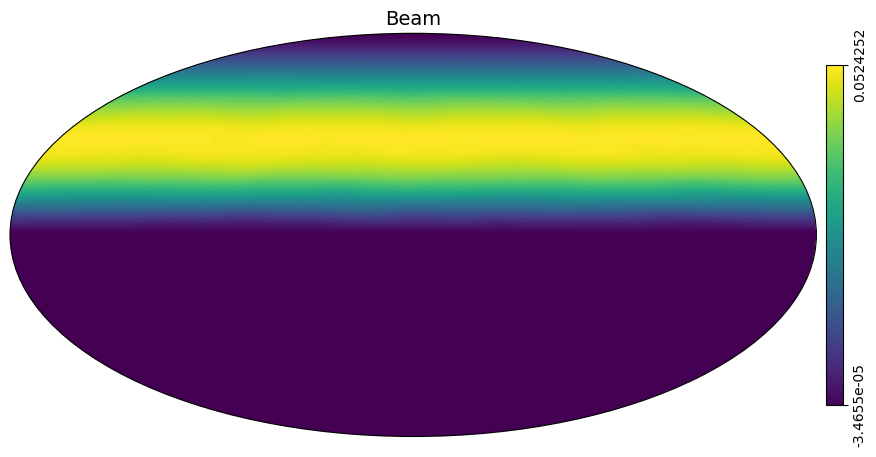

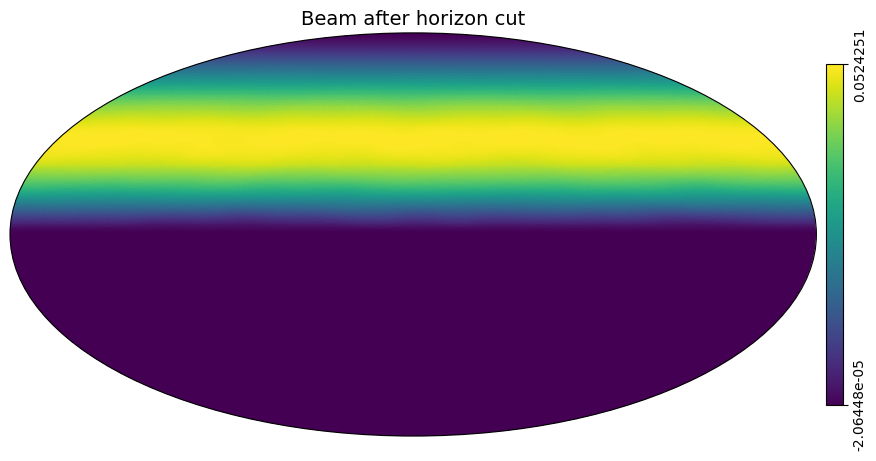

In [81]:
phi, theta, gain = np.loadtxt("GainPlot_FIORE_Moon_05MHz_monopole_6m.csv", delimiter=",", skiprows=1).T
cut = phi == 360
phi = np.unique(phi[~cut]) * np.pi / 180
theta = np.unique(theta[~cut]) * np.pi / 180
gain = gain[~cut].reshape(theta.size, phi.size)
beam = cro.Beam.from_grid(gain, theta, phi, lmax, nside=NSIDE, frequencies=FREQ, coord="T")

hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam", cb_orientation="vertical")
plt.show()

horizon = np.ones(NPIX)
theta = hp.pix2ang(NSIDE, np.arange(NPIX))[0]
horizon[theta > np.pi / 2] = 0
beam.horizon_cut(horizon=horizon)
hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam after horizon cut", cb_orientation="vertical")
plt.show()

In [82]:
# alm = np.zeros(hp.Alm.getsize(lmax))
# beam = cro.Beam(alm, lmax=lmax, coord="T", frequencies=FREQ)
# beam[0, 0] = 4/3 * np.sqrt(np.pi)
# #beam[1, 0] = np.sqrt(np.pi / 3)
# beam[2, 0] = - 4/3 * np.sqrt(np.pi / 5) #- np.sqrt(np.pi / 3)

# hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam", cb_orientation="vertical", min=0, max=1)
# plt.show()

# horizon = np.ones(NPIX)
# theta = hp.pix2ang(NSIDE, np.arange(NPIX))[0]
# horizon[theta > np.pi / 2] = 0
# beam.horizon_cut(horizon=horizon)
# hp.projview(beam.hp_map(NSIDE), cbar=True, title="Beam after horizon cut", cb_orientation="vertical", min=0, max=1)
# plt.show()

In [216]:
def all_alm(hp_alm, lmax=lmax):
    """
    Append negative m indices to alm array (these are -1^m * conjugate(positive alm) for m > 0)
    """
    sign = (-1) ** hp.Alm.getlm(lmax)[1][lmax+1:]  # -1^m for m > 0
    return np.append(hp_alm, sign * np.conj(hp_alm[..., lmax+1:]), axis=-1)

def hp_alm(all_alm, lmax=lmax):
    """
    Remove (redunant) negative m indices to recover healpy convention
    """
    return all_alm[..., :hp.Alm.getsize(lmax)]

def _gen_Ax(sim):
    phases = sim.sky.rot_alm_z(times=sim.dt, world=sim.world)
    if sim.lmax == 0:
        phases.shape = (-1, 1)
    A = all_alm(sim.beam.alm * phases, lmax=sim.lmax).conj() / sim.beam.total_power  # conjugated beam
    x = all_alm(sim.sky.alm, lmax=sim.lmax)  # sky
    return A, x

def estimate_x(sim, method="pinv", lmax_inv=lmax_inv):
    A_full, x_full = _gen_Ax(sim)
    ells, emms = hp.Alm.getlm(lmax_inv)
    ix_pos = hp.Alm.getidx(sim.lmax, ells, emms)  # for emm >= 0
    # negative emms come after the 0 & positive in the same order as the positive emms
    ix_neg = hp.Alm.getsize(sim.lmax) - sim.lmax - 1 + ix_pos[emms > 0]
    ix = np.append(ix_pos, ix_neg)
    A = A_full[:, ix]
    x = x_full[ix]
#    Ndiag = np.real(A@x)**2 / 1e7 * np.ones(sim.N_times)
    Ndiag = 1 / 1e7 * np.ones(sim.N_times)
    noise = np.random.normal(0, 1, Ndiag.size) * np.sqrt(Ndiag)
    N = np.diag(Ndiag)
    Ni = np.diag(1 / Ndiag)
    Ni_root = np.diag(1 / np.sqrt(Ndiag))
    
    if method == "pinv":
        u, s, vt = np.linalg.svd(np.conj(Ni_root @ A), full_matrices=False)
        cutoff = 1e-8
        large = s > cutoff
        #eps = 10
        eps = 0
        sinv = np.divide(1, s+eps, where=large)
        sinv[~large] = 0
        W = vt.T @ (sinv[:, None] * u.T) @ Ni_root
        
        plt.figure()
        plt.yscale("log")
        plt.plot(s, lw=2.5, label="S")
        plt.plot(sinv[large], lw=2.5, label="Sinv")
        plt.plot(s * sinv, lw=2.5, label="S * Sinv")
        #plt.axhline(cutoff, ls="--", c="k")
        plt.axhline(1, ls="--", c="k")
        #plt.xlim(0, 100)
        plt.legend()
        plt.show()

        
    elif method == "wiener":
        ellndx = np.concatenate((hp.Alm.getlm(lmax_inv)[0], hp.Alm.getlm(lmax_inv)[0][lmax_inv+1:]))
        Sell = [(np.abs(x[ellndx==l_])**2).mean() for l_ in range(lmax_inv+1)]  # Cll power spectrum
        Sdiag = np.array([Sell[l_] for l_ in ellndx])
        S = np.diag(Sdiag)
        W = S @ A.T.conj() @ np.linalg.inv(A @ S @ A.T.conj() + N) 
    
    elif method == "tik":
        eps = 1  # large -> suppress noisy modes
        Sinv = eps * np.eye(A.shape[1])  # tikhonov regularization
        T = A.T.conj() @ Ni @ A + Sinv
        W = np.linalg.inv(T) @ A.T.conj() @ Ni
    
    elif method == "lsq":
        T = A.T.conj() @ Ni @ A
        W = np.linalg.inv(T) @ A.T.conj() @ Ni

    return A_full, x_full, W, noise

In [217]:
from lunarsky import Time
from astropy.units import s

location = (0, 40) # lon, lat
t_start = Time("2023-02-28 16:31")
delta_t = ndays / ntimes
# convert delta t to seconds
if moon:
    delta_t *= cro.constants.sidereal_day_moon * s
else:
    delta_t *= cro.constants.sidereal_day_earth * s

times = cro.simulator.time_array(t_start=t_start, N_times=ntimes, delta_t=delta_t)

if moon:
    world = "moon"
else:
    world = "earth"

In [218]:
# point source at equator
smap = np.ones(NPIX)
src_ix = hp.ang2pix(NSIDE, 0, 30, lonlat=True)
smap[src_ix] = 1e4
#smap -= smap.mean(keepdims=True)
hp_sky = cro.healpix.HealpixMap(smap, frequencies=beam.frequencies, coord="C")
sky = cro.Sky.from_healpix(hp_sky, lmax=lmax)
#sky[0, 0] = 0  # subtract mean

sim = cro.Simulator(beam, sky, lmax=lmax, world=world, location=location, times=times)

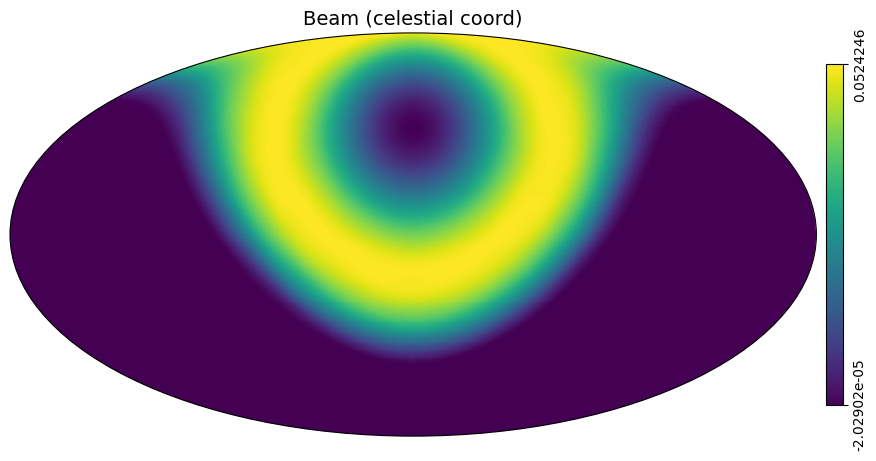

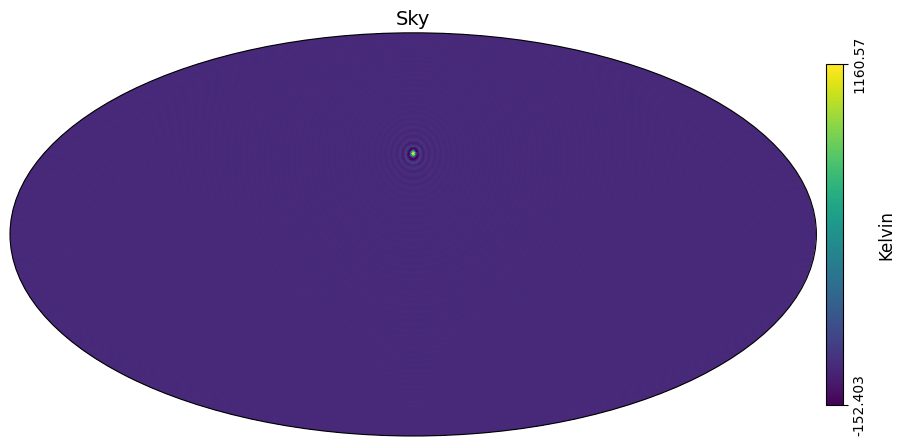

In [219]:
hp.projview(sim.beam.hp_map(NSIDE), cbar=True, title="Beam (celestial coord)", cb_orientation="vertical")
hp.projview(sky.hp_map(NSIDE), cbar=True, title="Sky", cb_orientation="vertical", unit="Kelvin")
plt.show()

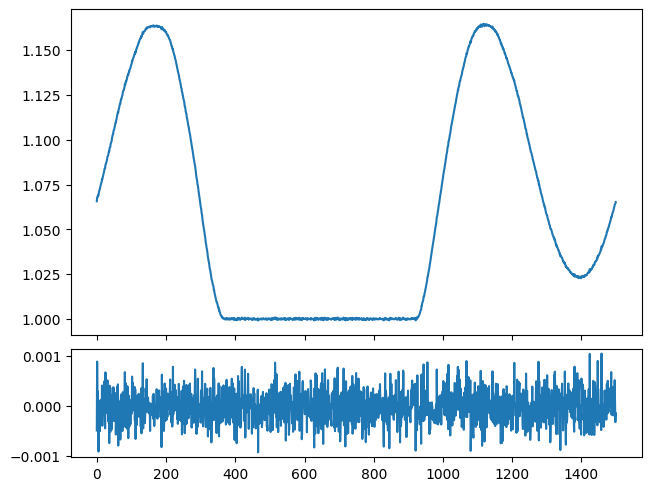

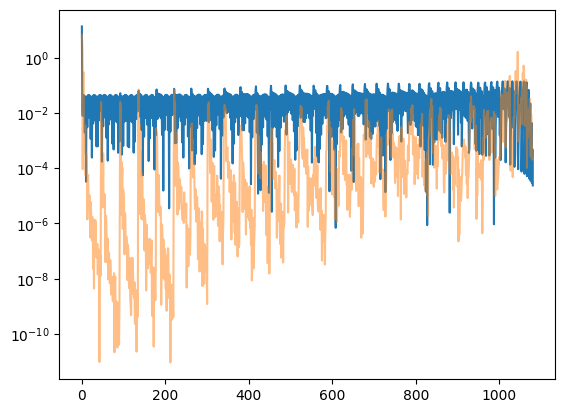

In [220]:
A, x, W, noise = estimate_x(sim, method="tik")
y = np.real(A @ x) + noise
res = W @ y
x_est = hp_alm(res, lmax=lmax_inv)

fig, axs = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios":[3, 1]}, constrained_layout=True)
axs[0].plot(y)
axs[1].plot(noise)
plt.show()

sim.sky.reduce_lmax(lmax_inv)
plt.figure()
plt.plot(np.abs(sim.sky.alm)**2)
plt.plot(np.abs(x_est)**2, alpha=.5)
plt.yscale("log")
plt.show()

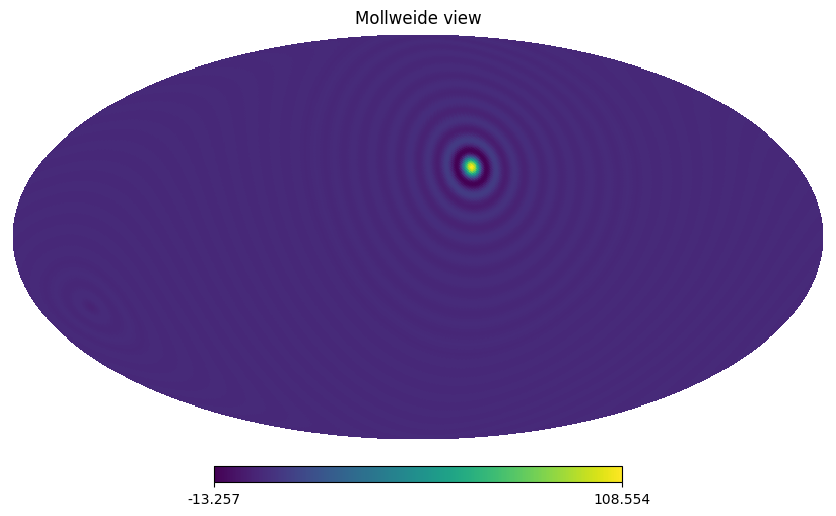

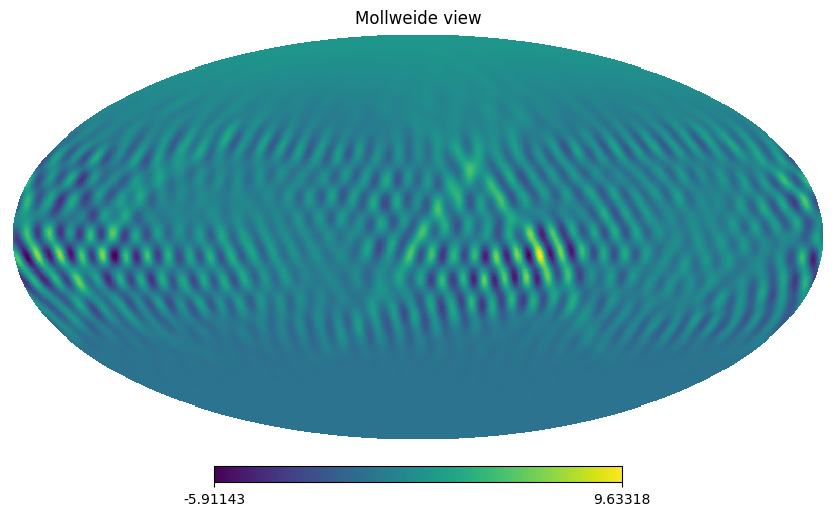

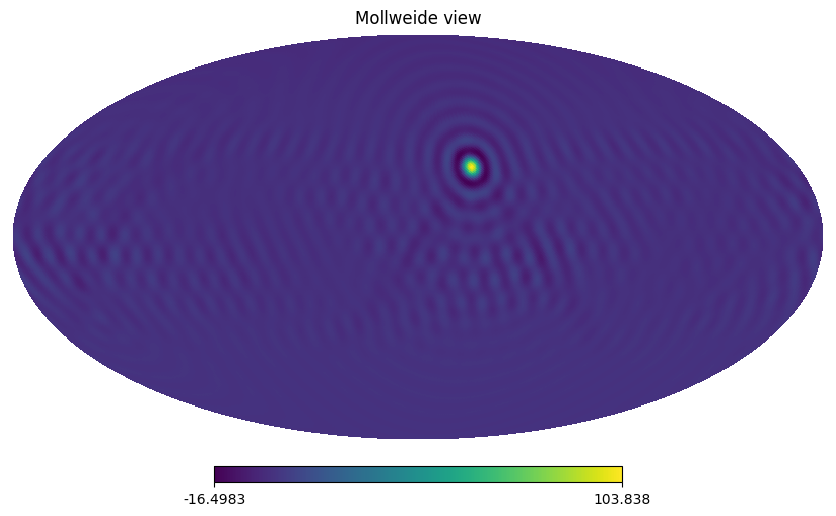

In [221]:
map_true = hp.alm2map(sim.sky.alm, NSIDE)
map_est = hp.alm2map(x_est, NSIDE)

hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)

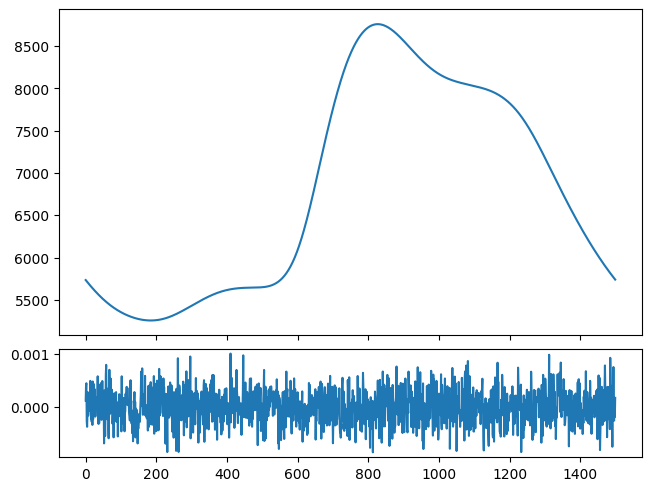

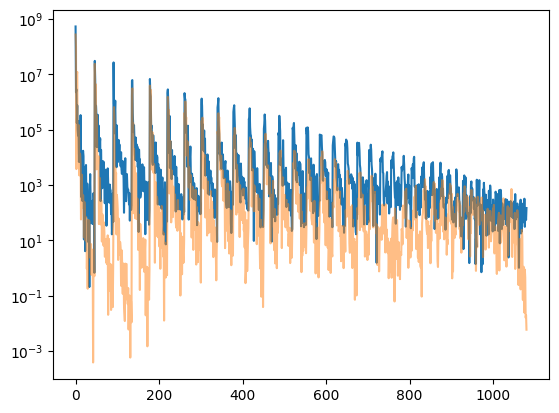

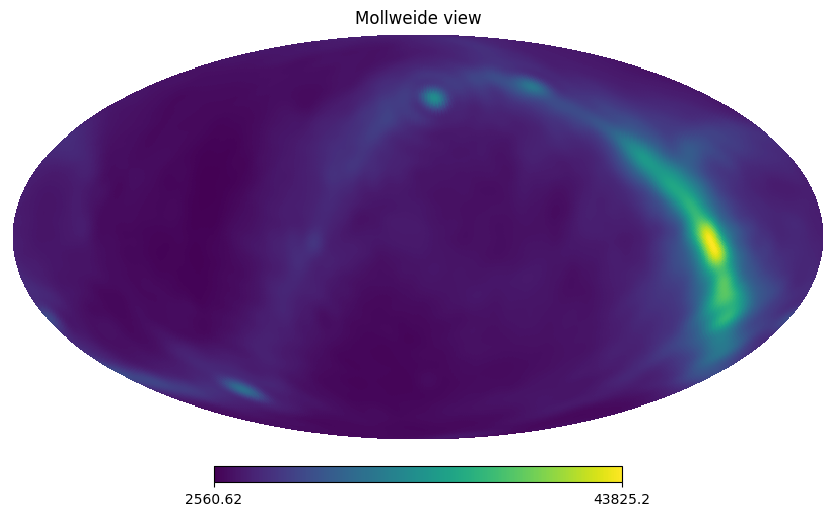

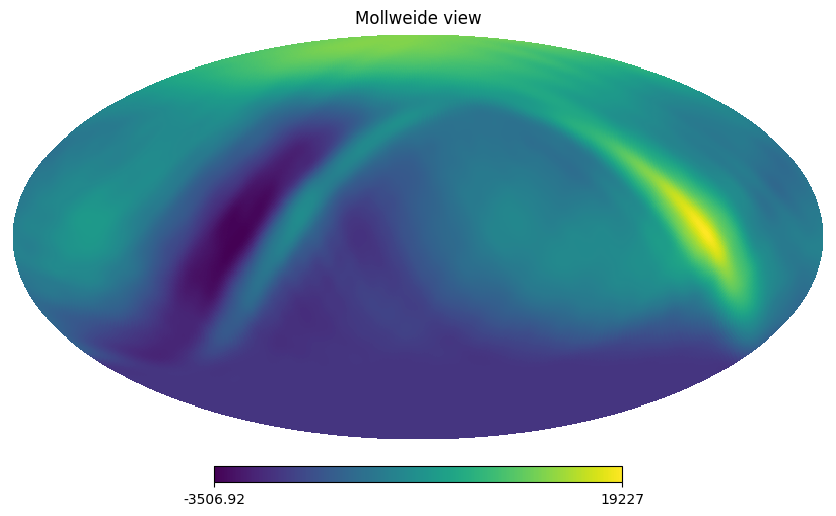

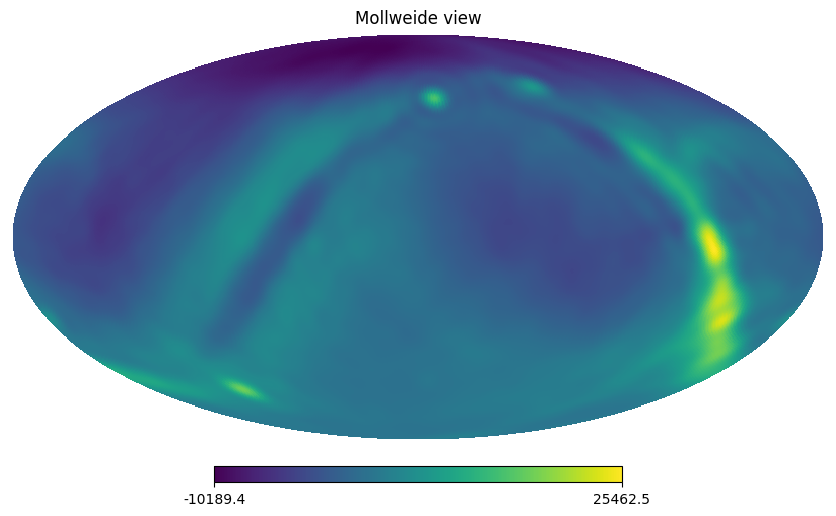

In [223]:
# gsm
sky = cro.Sky.gsm(beam.frequencies, lmax=lmax)
#sky[0, 0] = 0  # subtract mean
sim = cro.Simulator(beam, sky, lmax=lmax, world=world, location=location, times=times)
A, x, W, noise = estimate_x(sim, method="tik")
y = np.real(A @ x) + noise
res = W @ y
x_est = hp_alm(res, lmax=lmax_inv)
sim.sky.reduce_lmax(lmax_inv)

fig, axs = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios":[3, 1]}, constrained_layout=True)
axs[0].plot(y)
axs[1].plot(noise)
plt.show()

plt.figure()
plt.plot(np.abs(sim.sky.alm)**2)
plt.plot(np.abs(x_est)**2, alpha=.5)
plt.yscale("log")
plt.show()

map_true = hp.alm2map(sim.sky.alm, NSIDE)
map_est = hp.alm2map(x_est, NSIDE)
hp.mollview(map_true)
hp.mollview(map_est)
hp.mollview(map_true - map_est)